In [44]:
import sys
root_path = "/Users/sa/CS/stanford/cs229/Project/Neural-Response-Generator-augmented-with-psychological-personalities/"

import pandas as pd
import autoreload

# essentials
import numpy as np
from tqdm.notebook import tqdm
import pickle

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
X_train, X_val, y_train, y_val = np.load(open(root_path + "data/intermediate/final/MBTI_features.pkl", "rb"), allow_pickle=True)

In [55]:
def model_comparison(model, X_train, X_test, y_train, y_test, name):
    strat_k_fold = StratifiedKFold(n_splits=3, shuffle=True)
    model.fit(X_train, y_train)
    accuracy     = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='accuracy', n_jobs=-1, verbose=True))
    precision    = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='precision_weighted', n_jobs=-1, verbose=True))
    recall       = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='recall_weighted', n_jobs=-1, verbose=True))
    f1score      = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='f1_weighted', n_jobs=-1, verbose=True))
    y_pred = model.predict(X_test)
    mcm = multilabel_confusion_matrix(y_test, y_pred)
    tn = mcm[:, 0, 0]
    tp = mcm[:, 1, 1]
    fn = mcm[:, 1, 0]
    fp = mcm[:, 0, 1]
    specificities = tn / (tn+fp)
    specificity = (specificities.sum())/ 16

    df_model = pd.DataFrame({'model'        : [name],
                             'accuracy'     : [accuracy],
                             'precision'    : [precision],
                             'recall'       : [recall],
                             'f1score'      : [f1score],
                             'specificity'  : [specificity]
                            })
    print ("done with: ", name)
    dump(model, root_path + 'models/final/' + name +'.joblib')
    return df_model


In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingRegressor

#Metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, multilabel_confusion_matrix

from joblib import dump, load


#models = {'gnb': GaussianNB()}
#models = {'logit': LogisticRegression(max_iter=1000)}
#models = {'MLPC': MLPClassifier(max_iter=1000)}

models = {'gnb': GaussianNB(),
           'logit': LogisticRegression(max_iter=1000, verbose=True, n_jobs=-1, warm_start=True),
           'xgboost': GradientBoostingClassifier(verbose=True, learning_rate=0.1, max_depth=3, subsample=1, n_estimators=1000, warm_start=True),
           'MLPC': MLPClassifier(max_iter=1000, hidden_layer_sizes=(1000,), verbose=True, warm_start=True),
          'MLPC100': MLPClassifier(max_iter=1000, verbose=True, warm_start=True)
          }

In [ ]:
models_df = pd.concat([model_comparison(model, X_train, X_val, y_train, y_val, name) for (name, model) in models.items()])
models_df.to_csv(root_path + 'models/final/model_results.csv')
models_df

In [114]:
models_df = pd.read_csv(root_path + 'models/final/model_results.csv')
models_df

,Unnamed: 0,model,accuracy,precision,recall,f1score,specificity
0,0,gnb,0.605205,0.611031,0.603029,0.601105,0.960990
1,0,logit,0.648806,0.652815,0.650725,0.642918,0.968313
2,0,xgboost,0.871544,0.872130,0.872014,0.873653,0.963147
3,0,MLPC,0.907039,0.901114,0.903711,0.901855,0.965940
4,0,MLPC100,0.853968,0.847645,0.859428,0.847591,0.962659


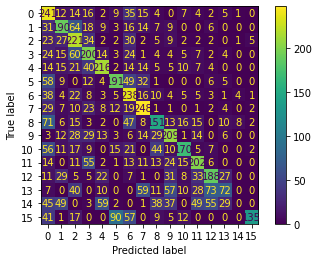

In [73]:
name = 'mlpc'
clf = load(root_path + 'models/final/' + name +'.joblib') 

from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(clf, X_val, y_val)